In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd

In [191]:
def count_outliers_iqr(df, multiplier=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    outlier_counts = ((df < lower) | (df > upper)).sum()
    return outlier_counts

In [192]:
train = pd.read_csv("train.csv")
formula_train = pd.read_csv("formula_train.csv")
formula_train.head()
formula_train = formula_train.drop(columns=['critical_temp'])

In [ ]:
test = pd.read_csv("test.csv")
formula_test = pd.read_csv("formula_test.csv")
train.info()
formula_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17010 entries, 0 to 17009
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               17010 non-null  int64  
 1   mean_atomic_mass                 17010 non-null  float64
 2   wtd_mean_atomic_mass             17010 non-null  float64
 3   gmean_atomic_mass                17010 non-null  float64
 4   wtd_gmean_atomic_mass            17010 non-null  float64
 5   entropy_atomic_mass              17010 non-null  float64
 6   wtd_entropy_atomic_mass          17010 non-null  float64
 7   range_atomic_mass                17010 non-null  float64
 8   wtd_range_atomic_mass            17010 non-null  float64
 9   std_atomic_mass                  17010 non-null  float64
 10  wtd_std_atomic_mass              17010 non-null  float64
 11  mean_fie                         17010 non-null  float64
 12  wtd_mean_fie      

In [194]:
train.isnull().values.any()

False

In [ ]:
train_full = pd.concat([train, formula_train], axis=1)
test_full = pd.concat([test, formula_test], axis=1)
test_full.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,material
0,5,92.729214,61.051113,73.132787,37.513930,1.449309,1.146919,122.90607,35.741099,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Ag0.5Cu0.5O4
1,4,64.632217,55.790060,48.775792,35.178830,1.139875,0.931491,122.90607,35.851917,46.059083,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,La1.85Ca0.15Cu1O4
2,4,76.444563,65.834647,59.356672,48.955994,1.199541,1.241867,121.32760,22.132267,43.823354,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Y0.4Ba0.6Cu1O
3,4,96.032850,77.279467,69.515930,53.611120,1.159784,1.267452,151.25960,22.543367,59.663892,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Er0.5Ba0.5Cu1O
4,4,96.451652,75.978308,69.689342,53.146925,1.158346,1.259726,152.93481,24.421050,60.166149,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Tm0.35Ba0.65Cu1O


In [196]:
train_full.drop(columns=['material'], inplace=True)
test_full.drop(columns=['material'], inplace=True)

In [ ]:

corr = train.corr().abs()
high_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if corr.iloc[i, j] > 0.95:
            col1 = corr.columns[i]
            col2 = corr.columns[j]
            high_corr_pairs.append((col1, col2, corr.iloc[i, j]))
for col1, col2, value in high_corr_pairs:
    print(f"{col1} — {col2}: {value:.4f}")

number_of_elements — entropy_fie: 0.9729
number_of_elements — entropy_atomic_radius: 0.9719
number_of_elements — entropy_Valence: 0.9676
wtd_mean_atomic_mass — wtd_gmean_atomic_mass: 0.9650
entropy_atomic_mass — entropy_fie: 0.9650
entropy_atomic_mass — entropy_atomic_radius: 0.9727
entropy_atomic_mass — entropy_Valence: 0.9636
wtd_entropy_atomic_mass — wtd_entropy_atomic_radius: 0.9621
range_atomic_mass — std_atomic_mass: 0.9612
mean_fie — gmean_fie: 0.9694
wtd_mean_fie — wtd_gmean_fie: 0.9923
entropy_fie — entropy_atomic_radius: 0.9977
entropy_fie — entropy_Valence: 0.9927
range_fie — std_fie: 0.9816
wtd_mean_atomic_radius — wtd_gmean_atomic_radius: 0.9801
entropy_atomic_radius — entropy_Valence: 0.9895
wtd_entropy_atomic_radius — wtd_entropy_Valence: 0.9517
range_atomic_radius — std_atomic_radius: 0.9675
range_atomic_radius — wtd_std_atomic_radius: 0.9579
gmean_Density — wtd_gmean_Density: 0.9515
range_Density — std_Density: 0.9602
range_ElectronAffinity — std_ElectronAffinity: 0.97

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
corr = train.corr().abs()
dist = 1 - corr
link = linkage(squareform(dist), method='average')
clusters = fcluster(link, t=0.3, criterion='distance')
cluster_groups = {}
for col, cluster_id in zip(corr.columns, clusters):
    cluster_groups.setdefault(cluster_id, []).append(col)
cluster_groups

{18: ['number_of_elements',
  'entropy_atomic_mass',
  'wtd_entropy_atomic_mass',
  'entropy_fie',
  'entropy_atomic_radius',
  'wtd_entropy_atomic_radius',
  'entropy_Density',
  'wtd_entropy_Density',
  'entropy_ElectronAffinity',
  'entropy_FusionHeat',
  'wtd_entropy_FusionHeat',
  'entropy_Valence',
  'wtd_entropy_Valence'],
 13: ['mean_atomic_mass',
  'wtd_mean_atomic_mass',
  'gmean_atomic_mass',
  'wtd_gmean_atomic_mass'],
 11: ['range_atomic_mass', 'std_atomic_mass', 'wtd_std_atomic_mass'],
 14: ['wtd_range_atomic_mass', 'wtd_range_Density'],
 10: ['mean_fie', 'gmean_fie', 'mean_atomic_radius', 'gmean_atomic_radius'],
 19: ['wtd_mean_fie',
  'wtd_gmean_fie',
  'wtd_mean_atomic_radius',
  'wtd_gmean_atomic_radius'],
 17: ['wtd_entropy_fie', 'wtd_entropy_ElectronAffinity'],
 21: ['range_fie',
  'std_fie',
  'wtd_std_fie',
  'range_atomic_radius',
  'std_atomic_radius',
  'wtd_std_atomic_radius',
  'mean_Density',
  'wtd_mean_Density',
  'gmean_Density',
  'wtd_gmean_Density',
  

In [199]:
skewness = train.skew()
groups = {
    "strong_right": skewness[skewness > 1].index.tolist(),
    "moderate_right": skewness[(skewness > 0.3) & (skewness <= 1)].index.tolist(),
    "symmetric": skewness[(skewness >= -0.3) & (skewness <= 0.3)].index.tolist(),
    "moderate_left": skewness[(skewness >= -1) & (skewness < -0.3)].index.tolist(),
    "strong_left": skewness[skewness < -1].index.tolist(),
}
sample_features = {
    name: (cols[2] if len(cols) > 0 else None)
    for name, cols in groups.items()
}

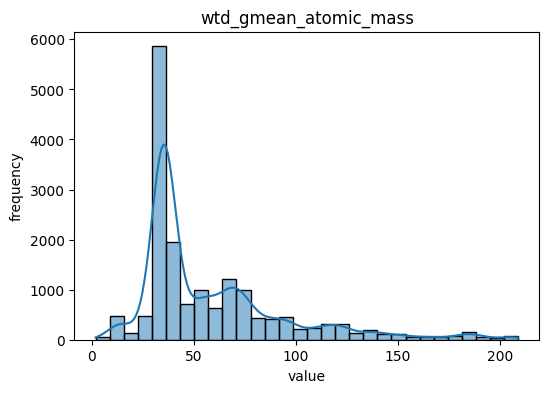

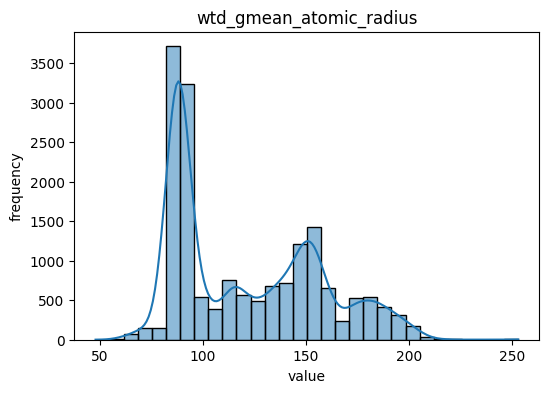

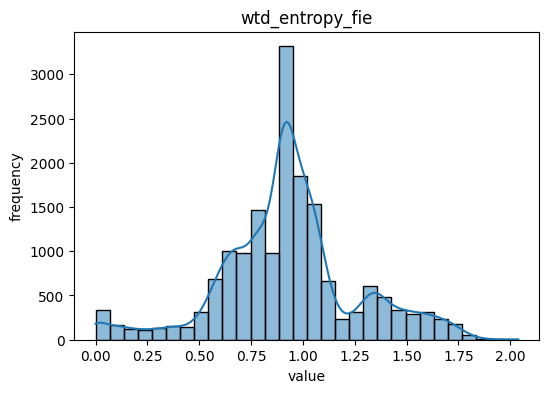

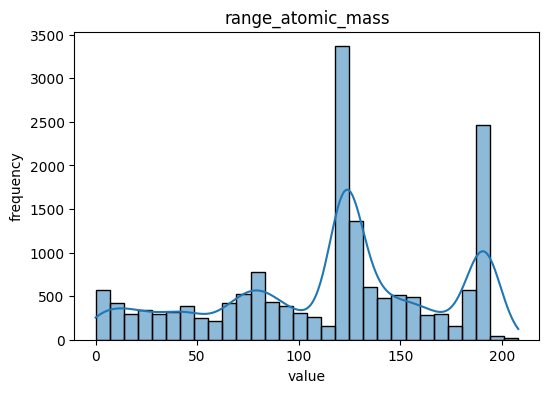

In [ ]:
for group_name, feature in sample_features.items():
    if feature is None:
        continue
    plt.figure(figsize=(6, 4))
    sns.histplot(train[feature], bins=30, kde=True)
    plt.title(f"{feature}")
    plt.xlabel("value")
    plt.ylabel("frequency")
    plt.show()

#### Процент выбросов в столбцах

In [201]:
outliers = count_outliers_iqr(train)
summary = pd.DataFrame({
    "outliers": outliers,
    "percent": (outliers / len(train) * 100)
})
print(summary.sort_values("percent", ascending=False))
percent_outliers = outliers / len(train) * 100
cols_to_drop = percent_outliers[percent_outliers > 12].index.tolist()
print(cols_to_drop)

                              outliers    percent
std_Density                       2753  16.184597
wtd_entropy_ElectronAffinity      2727  16.031746
gmean_atomic_mass                 2668  15.684891
range_Density                     2315  13.609641
wtd_std_FusionHeat                2104  12.369195
...                                ...        ...
wtd_std_fie                          0   0.000000
wtd_entropy_atomic_radius            0   0.000000
range_atomic_radius                  0   0.000000
std_atomic_radius                    0   0.000000
std_ThermalConductivity              0   0.000000

[82 rows x 2 columns]
['gmean_atomic_mass', 'range_Density', 'std_Density', 'wtd_entropy_ElectronAffinity', 'wtd_std_FusionHeat']


In [202]:

# train = train.drop(columns=cols_to_drop)
# test = test.drop(columns=cols_to_drop)
# train = train.drop(columns=wtd_cols)
# test = test.drop(columns=wtd_cols)

# 0. Удаляем дубликаты признаков в обоих датасетах
# train_red = train.drop(columns=columns_to_drop)
# test_red = test.drop(columns=columns_to_drop)

#### Делим на признаки и целевую переменную

In [203]:
X_train = train_full.drop(columns=["critical_temp"])
y_train = train_full["critical_temp"]
X_test = test_full

#### MinMax нормировка

In [204]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Модель линейной регрессии

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print(y_train)
y_pred = model.predict(X_test_scaled)

0         29.00
1         26.00
2         19.00
3         22.00
4         23.00
          ...  
17005      2.44
17006    122.10
17007      1.98
17008      1.84
17009     12.80
Name: critical_temp, Length: 17010, dtype: float64


#### Вывод результатов в файл

In [206]:
submit_index = range(len(X_test_scaled))
print(submit_index)
print(y_pred)
submission = pd.DataFrame({
    "index": submit_index,
    "critical_temp": y_pred
})
submission = submission[["index", "critical_temp"]]
submission.to_csv("submission.csv", index=False)
submission.info()

range(0, 4253)
[42.11079012 25.40662317 68.5848528  ...  0.15656144 18.54899465
 18.54899465]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4253 entries, 0 to 4252
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          4253 non-null   int64  
 1   critical_temp  4253 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 66.6 KB
